In [1]:
import json
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def get_metrics_df(output_path, error_types, model_name, direction, type_=''):
    metrics_dict = defaultdict(list)

    for error in error_types:
        if type_ == 'base':
            if 'opus' in model_name:
                error_output_path = f'{output_path}/{model_name}-{direction}/{direction}/test'
            else:
                error_output_path = f'{output_path}/{model_name}/{direction}/test'
        elif type_ != '':
            error_output_path = f'{output_path}/{model_name}-{direction}-{error}-{type_}/metrics/test'
        else:
            error_output_path = f'{output_path}/{model_name}-{direction}-{error}/metrics/test'

        filename = f"../{error_output_path}/{error}_diff_metrics.json"
        metrics_dict["Error"].append(error.capitalize())
        metrics_dict["train_error"].append(error)
        with open(filename, 'r') as f:
            metrics = json.load(f)
            for k, v in metrics.items():
                metrics_dict[k].append(round(v, 2))

        filename = f"../{error_output_path}/translation_clean_metrics.json"
        with open(filename, 'r') as f:
            metrics = json.load(f)
            for k, v in metrics.items():
                metrics_dict[k+"-clean"].append(round(v, 2))

        filename = f"../{error_output_path}/translation_{error}_metrics.json"
        with open(filename, 'r') as f:
            metrics = json.load(f)
            for k, v in metrics.items():
                metrics_dict[k+"-noisy"].append(round(v, 2))

    df = pd.DataFrame.from_dict(metrics_dict)
    return df

/tmp/ipykernel_148899/3254049434.py:56: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.catplot(


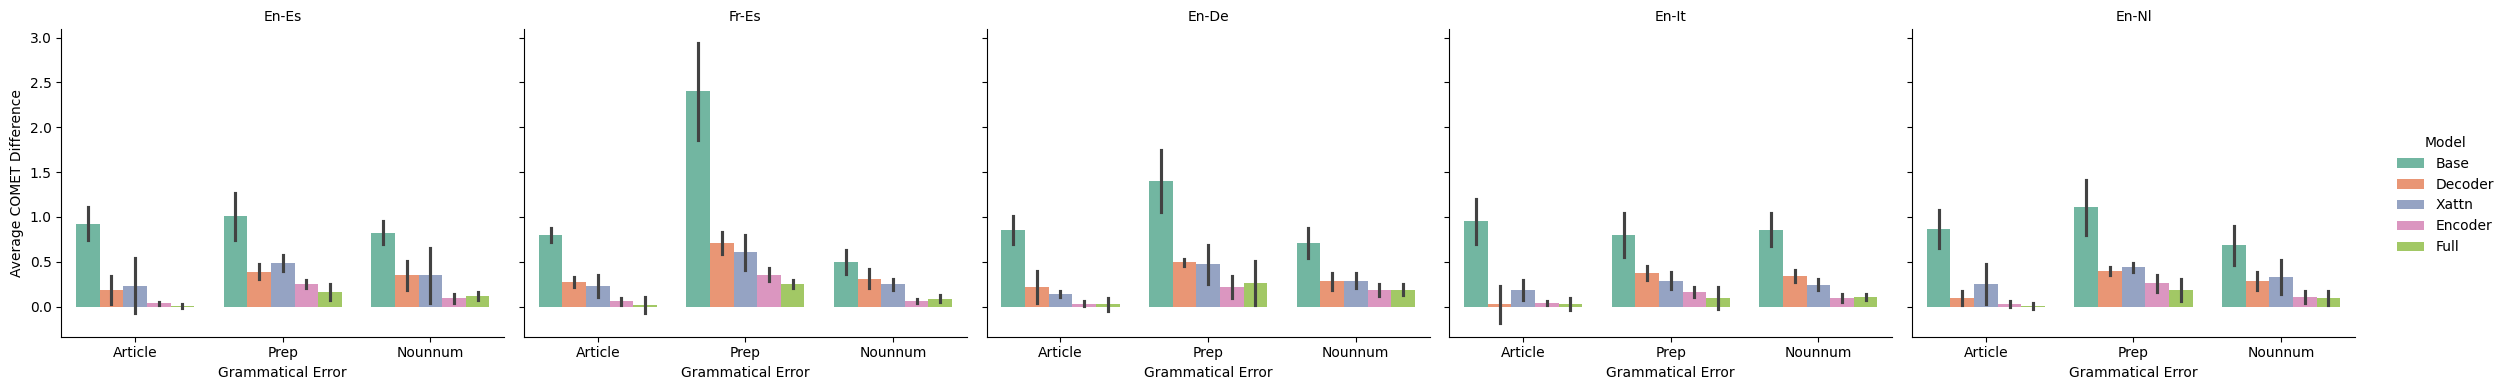

In [ ]:
base_model_dict = {
    'nllb': 'nllb-200-distilled-600M', 
    'mbart': 'mbart-large-50-many-to-many-mmt', 
    'm2m100': 'm2m100_418M',
    'opus': 'opus-mt'
}
error_types = ['article', 'prep', 'nounnum']
output_path = '../outputs/models'
hue_order = ['Base', 'Decoder', 'Xattn', 'Encoder', 'Full']
directions = ['en-es', 'fr-es', 'en-de', 'en-it', 'en-nl']

lang_dfs = []

for direction in directions:
    model_dfs = []  
    for model_prefix, model_name in base_model_dict.items():
        base_df = get_metrics_df(output_path=output_path, error_types=error_types, model_name=model_name, direction=direction, type_='base')
        base_df['Model'] = 'Base'  
        
        encoder_df = get_metrics_df(output_path=output_path, error_types=error_types, model_name=model_prefix, direction=direction)
        encoder_df['Model'] = 'Encoder'

        decoder_df = get_metrics_df(output_path=output_path, error_types=error_types, model_name=model_prefix, direction=direction, type_='decoder')
        decoder_df['Model'] = 'Decoder'

        xattn_df = get_metrics_df(output_path=output_path, error_types=error_types, model_name=model_prefix, direction=direction, type_='xattn')
        xattn_df['Model'] = 'Xattn'

        full_df = get_metrics_df(output_path=output_path, error_types=error_types, model_name=model_prefix, direction=direction, type_='full')
        full_df['Model'] = 'Full'

        df = pd.concat([base_df, encoder_df, decoder_df, xattn_df, full_df], axis=0)
        model_dfs.append(df)  
        
    direction_df = pd.concat(model_dfs, axis=0)
    direction_df['Direction'] = '-'.join([lang.capitalize() for lang in direction.split('-')])
    lang_dfs.append(direction_df) 

plot_df = pd.concat(lang_dfs, axis=0)

g = sns.catplot(
    data=plot_df, 
    x='Error', 
    y='COMET',  
    hue='Model',  
    col='Direction',  
    kind='bar',
    palette='Set2',
    height=4, 
    aspect=1.2,
    hue_order=hue_order,
    ci='sd'
)

g.set_axis_labels("Grammatical Error", "Average COMET Difference")
g.set_titles("{col_name}")  
g.tight_layout()

output_plot_path = '../figures/freezing/comet_difference_appendix.pdf'
plt.savefig(output_plot_path, dpi=300)

plt.show()